### ===To do===
- $\sigma$と幅の関係
- 期間を変える

### ==========

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import backward as bk
import forward as fw
import math

In [2]:
def backward_normal_rand(N, theta, u, d, p, default_value, mu, sigma):
    pi = ((((p*(u-1))/((1-p)*(1-d)))**theta)-1)/((u - 1)+(((p*(u-1))/((1-p)*(1-d)))**theta)*(1 - d))
    up_times = bk.up_times(N)
    down_times = bk.down_times(N)
    prm_theta = bk.prm_theta(N, theta)
    
    up_r = bk.up_r(N, u)
    up_r_norm_rand = list(map(lambda x,y: list(map(lambda a,b: a+b, x,y)), up_r, bk.norm_rand(N, seed, mu, sigma)))
    
    down_r = bk.down_r(N, d)
    down_r_norm_rand = list(map(lambda x,y: list(map(lambda a,b: a+b, x,y)), down_r, bk.norm_rand(N, seed, mu, sigma)))
    
    prob = bk.prob(N, p)
    prm_M = bk.prm_M(N, pi, prm_theta, up_r_norm_rand, down_r_norm_rand, prob)
    value = bk.value(N, pi, default_value, up_r_norm_rand, down_r_norm_rand)
    wealth = bk.wealth(N, prm_theta, prm_M, value)
    utility = bk.utility(N, prm_theta, value)
    exp_utility = bk.exp_utility(N, up_times, down_times, prob, utility)
    Wn = bk.Wn(N, up_times, down_times, prob, wealth)
    
    df_backward = pd.DataFrame([up_times, down_times, prm_theta, up_r_norm_rand, down_r_norm_rand, prob, prm_M, value, wealth, utility, exp_utility, Wn]).T
    df_backward.columns = ['up_times', 'down_times', 'prm_theta', 'up_r', 'down_r', 'prob', 'prm_M', 'value', 'wealth', 'utility', 'exp_utility', 'Wn']
    
    return df_backward#df_backward['exp_utility'][N], df_backward['wealth'][0] 

In [3]:
def forward_normal_rand(N, theta, u, d, p, default_value, mu, sigma):
    up_times = fw.up_times(N)
    down_times = fw.down_times(N)
    prm_theta = fw.prm_theta(N, theta)
    
    up_r = fw.up_r(N, u)
    up_r_norm_rand = list(map(lambda x,y: list(map(lambda a,b: a+b, x,y)), up_r, fw.norm_rand(N, seed, mu, sigma)))
    
    down_r = fw.down_r(N, d)
    down_r_norm_rand = list(map(lambda x,y: list(map(lambda a,b: a+b, x,y)), down_r, fw.norm_rand(N, seed, mu, sigma)))
    
    prob = fw.prob(N, p)
    prm_q = fw.prm_q(N, up_r_norm_rand, down_r_norm_rand)
    prm_a = fw.prm_a(N, prob, prm_q)
    prm_b = fw.prm_b(N, prm_q)
    prm_c = fw.prm_c(N, prob, prm_q)
    delta = fw.delta(N, prm_theta, prm_a, prm_b, prm_c)
    pi = fw.pi(N, prm_theta, up_r_norm_rand, prob, prm_q, delta)
    value = fw.value(N, default_value, up_r_norm_rand, down_r_norm_rand, pi)
    U0 = fw.U0(N, prm_theta, value)
    I0 = fw.I0(N, prm_theta, value)
    I1 = fw.I1(N, delta, I0)
    U1 = fw.U1(N, prm_theta, delta, U0)
    exp_U1 = fw.exp_U1(N, up_times, down_times, prob, U1)
    
    df_forward = pd.DataFrame([up_times, down_times, prm_theta, up_r_norm_rand, down_r_norm_rand, prob, prm_q, prm_a, prm_b, prm_c, delta, pi, value, U0, I0, I1, U1, exp_U1]).T
    df_forward.columns = ['up_times', 'down_times', 'prm_theta', 'up_r', 'down_r', 'prob', 'prm_q', 'prm_a', 'prm_b', 'prm_c', 'delta', 'pi', 'value', 'U0', 'I0', 'I1', 'U1', 'exp_U1']
    
    return df_forward#df_forward["exp_U1"][N]

In [4]:
def default_plot_normal(N, theta, u, d, p, default_value, mu, sigma):
    default_arr = []
    
    for i in range(1, 11):
        default_arr.append(500*i)
        forward_backward_diff = [list(map(lambda x: x, default_arr)), list(map(lambda x: sum(forward_normal_rand(N, theta, u, d, p, x, mu, sigma)["exp_U1"][N]) - sum(backward_normal_rand(N, theta, u, d, p, x, mu, sigma)["exp_utility"][N]), default_arr))]

    diff = pd.DataFrame(forward_backward_diff).T
    diff.columns = ["default", "Exp_diff"]

    diff_x = diff["default"]
    diff_y = diff["Exp_diff"]
    
    sns.set()
    sns.set_style('white')
    plt.figure(figsize=(20,10))
    plt.plot(diff_x, diff_y, label = "FW-DP-diff")

    plt.title(r"$\theta =$" +str(theta), fontsize=32)
    plt.xlabel(r"$x_0$", fontsize=32)
    plt.ylabel(r"$E[u(V_T^*)]$", fontsize=32)

    plt.tick_params(labelsize=24)
    plt.legend(fontsize=32)
    return plt.show()

In [5]:
def default_plot_y_normal(N, theta, u, d, p, default_value, mu, sigma):
    default_arr = []

    for i in range(1, 11):
        default_arr.append(500*i)
        forward_backward_diff = [list(map(lambda x: x, default_arr)), list(map(lambda x: math.pow(sum(forward_normal_rand(N, theta, u, d, p, x, mu, sigma)["exp_U1"][N])*(1-1/theta), 1/(1-(1/theta))) - math.pow(sum(backward_normal_rand(N, theta, u, d, p, x, mu, sigma)["exp_utility"][N])*(1-1/theta), 1/(1-(1/theta))), default_arr))]

    diff = pd.DataFrame(forward_backward_diff).T
    diff.columns = ["default", "Exp_diff"]

    diff_x = diff["default"]
    diff_y = diff["Exp_diff"]

    plt.figure(figsize=(20,10))
    plt.plot(diff_x, diff_y, label = "FW-DP-diff")

    plt.title(r"$\theta =$" +str(theta), fontsize=32)
    plt.xlabel(r"$x_0$", fontsize=32)
    plt.ylabel(r"$y$", fontsize=32)

    plt.tick_params(labelsize=24)
    plt.legend(fontsize=32)
    return plt.show()

### 正規乱数で差を見る

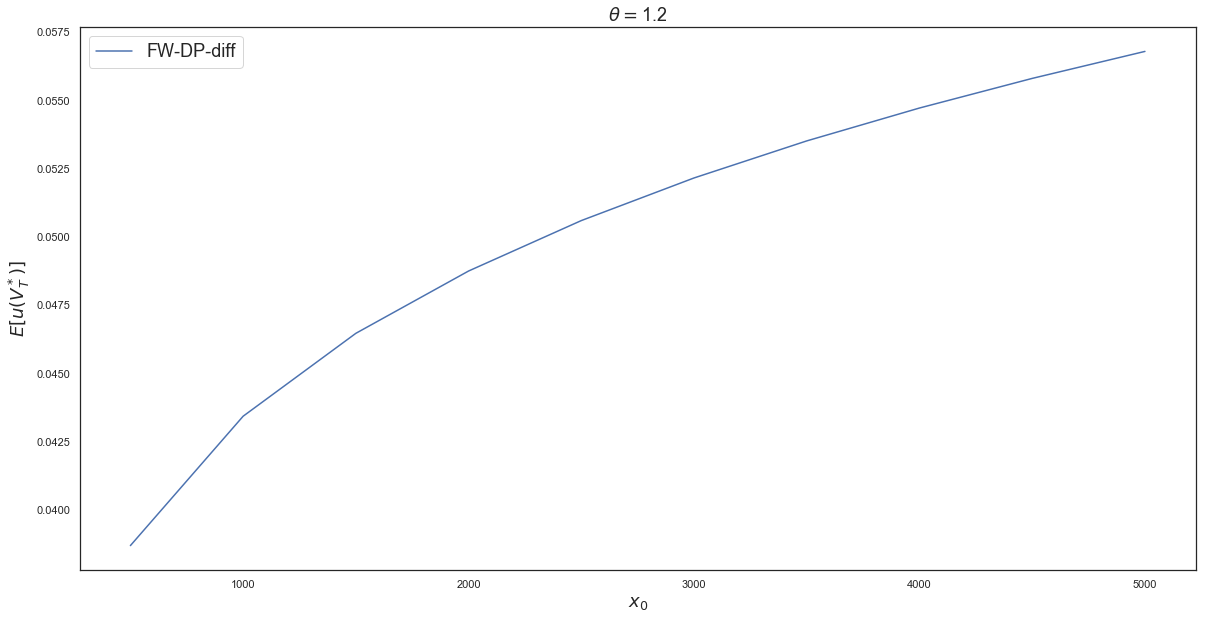

In [11]:
default_plot_normal(N, theta, u, d, p, default_value, mu, sigma)

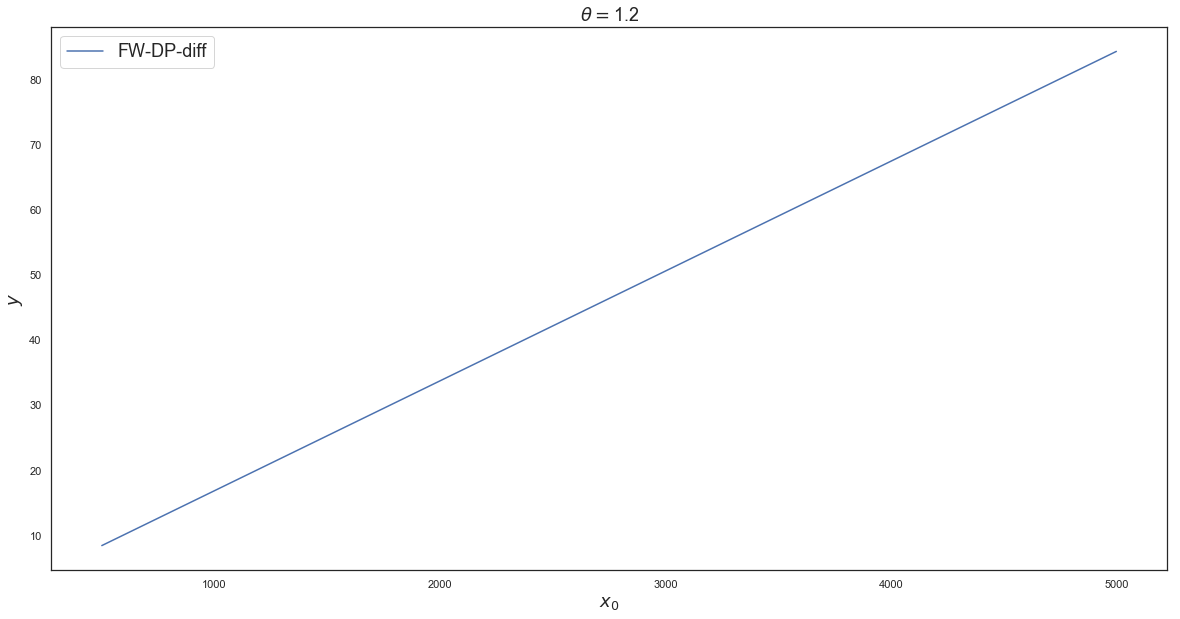

In [14]:
default_plot_y_normal(N, theta, u, d, p, default_value, mu, sigma)

In [98]:
def default_plot_normal_sigma(N, theta, u, d, p, default_value, mu, sigma):
    sigma_arr = []
    
    for i in range(1, 11):
        sigma_arr.append(0.001*i)
        forward_backward_diff_theta_12 = [list(map(lambda x: x, sigma_arr)), list(map(lambda x: sum(forward_normal_rand(N, 1.2, u, d, p, default_value, mu, x)["exp_U1"][N]) - sum(backward_normal_rand(N, 1.2, u, d, p, default_value, mu, x)["exp_utility"][N]), sigma_arr))]

    diff_theta_12 = pd.DataFrame(forward_backward_diff_theta_12).T
    diff_theta_12.columns = ["default", "Exp_diff"]

    diff_x_theta_12 = diff_theta_12["default"]
    diff_y_theta_12 = diff_theta_12["Exp_diff"]
    
    for i in range(1, 11):
        forward_backward_diff_theta_20 = [list(map(lambda x: x, sigma_arr)), list(map(lambda x: sum(forward_normal_rand(N, 2.0, u, d, p, default_value, mu, x)["exp_U1"][N]) - sum(backward_normal_rand(N, 2.0, u, d, p, default_value, mu, x)["exp_utility"][N]), sigma_arr))]

    diff_theta_20 = pd.DataFrame(forward_backward_diff_theta_20).T
    diff_theta_20.columns = ["default", "Exp_diff"]

    diff_x_theta_20 = diff_theta_20["default"]
    diff_y_theta_20 = diff_theta_20["Exp_diff"]
    
    for i in range(1, 11):
        forward_backward_diff_theta_30 = [list(map(lambda x: x, sigma_arr)), list(map(lambda x: sum(forward_normal_rand(N, 3.0, u, d, p, default_value, mu, x)["exp_U1"][N]) - sum(backward_normal_rand(N, 3.0, u, d, p, default_value, mu, x)["exp_utility"][N]), sigma_arr))]

    diff_theta_30 = pd.DataFrame(forward_backward_diff_theta_30).T
    diff_theta_30.columns = ["default", "Exp_diff"]

    diff_x_theta_30 = diff_theta_30["default"]
    diff_y_theta_30 = diff_theta_30["Exp_diff"]
    
    sns.set()
    sns.set_style('white')
    plt.figure(figsize=(20,10))
    plt.plot(diff_x_theta_12, diff_y_theta_12, label = r"$\theta$ = 1.2")
    plt.plot(diff_x_theta_20, diff_y_theta_20, label = r"$\theta$ = 2.0")
    plt.plot(diff_x_theta_30, diff_y_theta_30, label = r"$\theta$ = 3.0")

    #plt.title(r"$\theta =$" +str(theta), fontsize=18)
    plt.xlabel(r"$s$", fontsize=32)  
    plt.ylabel(r"$E[u(V_T^*)]$-diff", fontsize=32)
    plt.grid()

    plt.tick_params(labelsize=24)
    plt.legend(fontsize=32)
    return plt.show()

In [71]:
def default_plot_normal_N(N, theta, u, d, p, default_value, mu, sigma):
    N_arr = []
    
    for i in range(1, 11):
        N_arr.append(i)
        forward_backward_diff_theta_12 = [list(map(lambda x: x, N_arr)), list(map(lambda x: sum(forward_normal_rand(x, 1.2, u, d, p, default_value, mu, sigma)["exp_U1"][x]) - sum(backward_normal_rand(x, 1.2, u, d, p, default_value, mu, sigma)["exp_utility"][x]), N_arr))]

    diff_theta_12 = pd.DataFrame(forward_backward_diff_theta_12).T
    diff_theta_12.columns = ["default", "Exp_diff"]

    diff_x_theta_12 = diff_theta_12["default"]
    diff_y_theta_12 = diff_theta_12["Exp_diff"]
    
    for i in range(1, 11):
        forward_backward_diff_theta_20 = [list(map(lambda x: x, N_arr)), list(map(lambda x: sum(forward_normal_rand(x, 2.0, u, d, p, default_value, mu, sigma)["exp_U1"][x]) - sum(backward_normal_rand(x, 2.0, u, d, p, default_value, mu, sigma)["exp_utility"][x]), N_arr))]

    diff_theta_20 = pd.DataFrame(forward_backward_diff_theta_20).T
    diff_theta_20.columns = ["default", "Exp_diff"]

    diff_x_theta_20 = diff_theta_20["default"]
    diff_y_theta_20 = diff_theta_20["Exp_diff"]
    
    for i in range(1, 11):
        forward_backward_diff_theta_30 = [list(map(lambda x: x, N_arr)), list(map(lambda x: sum(forward_normal_rand(x, 3.0, u, d, p, default_value, mu, sigma)["exp_U1"][x]) - sum(backward_normal_rand(x, 3.0, u, d, p, default_value, mu, sigma)["exp_utility"][x]), N_arr))]

    diff_theta_30 = pd.DataFrame(forward_backward_diff_theta_30).T
    diff_theta_30.columns = ["default", "Exp_diff"]

    diff_x_theta_30 = diff_theta_30["default"]
    diff_y_theta_30 = diff_theta_30["Exp_diff"]
       
    sns.set()
    sns.set_style('white')
    plt.figure(figsize=(20,10))
    plt.plot(diff_x_theta_12, diff_y_theta_12, label = r"$\theta$ = 1.2")
    plt.plot(diff_x_theta_20, diff_y_theta_20, label = r"$\theta$ = 2.0")
    plt.plot(diff_x_theta_30, diff_y_theta_30, label = r"$\theta$ = 3.0")

    plt.title(r"$s =$" +str(sigma), fontsize=32)
    plt.xlabel(r"$N$", fontsize=32)  
    plt.ylabel(r"$E[u(V_T^*)]$-diff", fontsize=32)
    plt.grid()

    plt.tick_params(labelsize=24)
    plt.legend(fontsize=32)
    return plt.show()

In [72]:
seed = 12345
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma=0.01

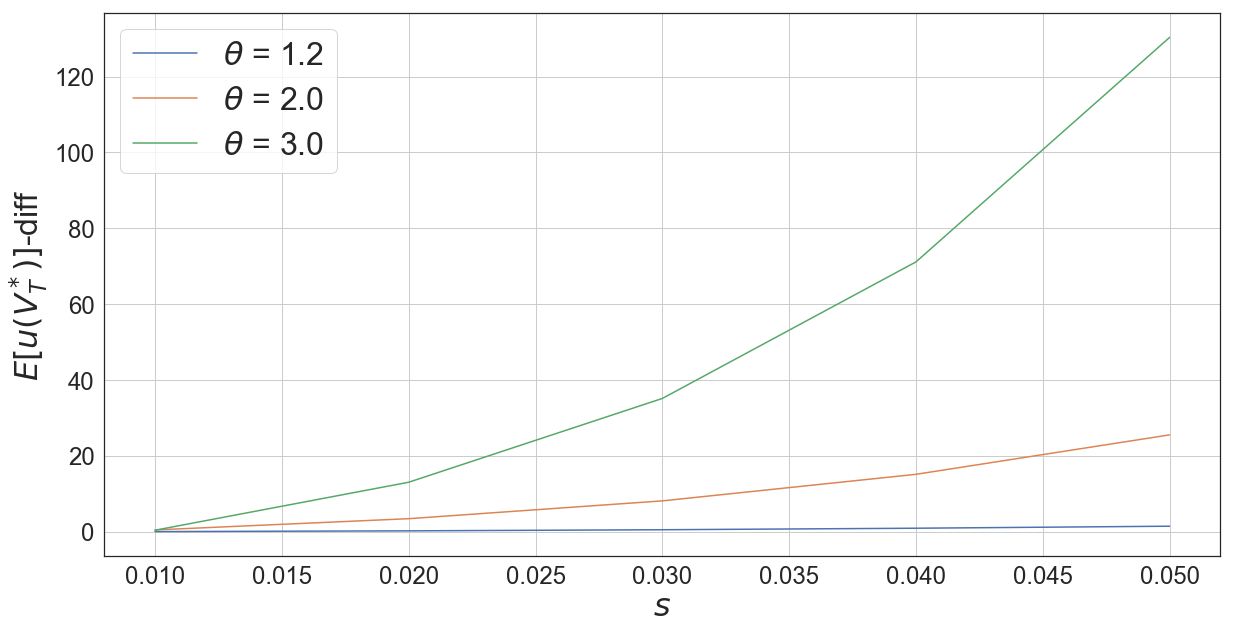

In [73]:
default_plot_normal_sigma(N, theta, u, d, p, default_value, mu, sigma)

In [74]:
seed = 12345
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma=0.01

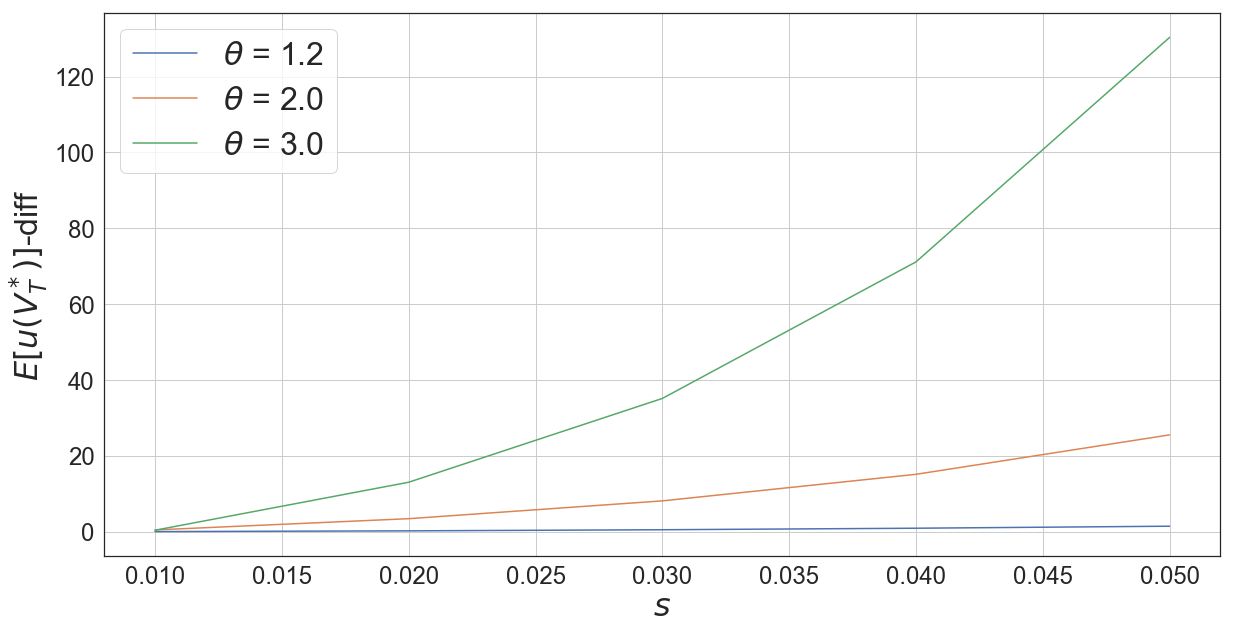

In [75]:
default_plot_normal_sigma(N, theta, u, d, p, default_value, mu, sigma)

### seedをいろいろ変えてみて収束具合を見る

In [103]:
seed = 12345
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma=0.01

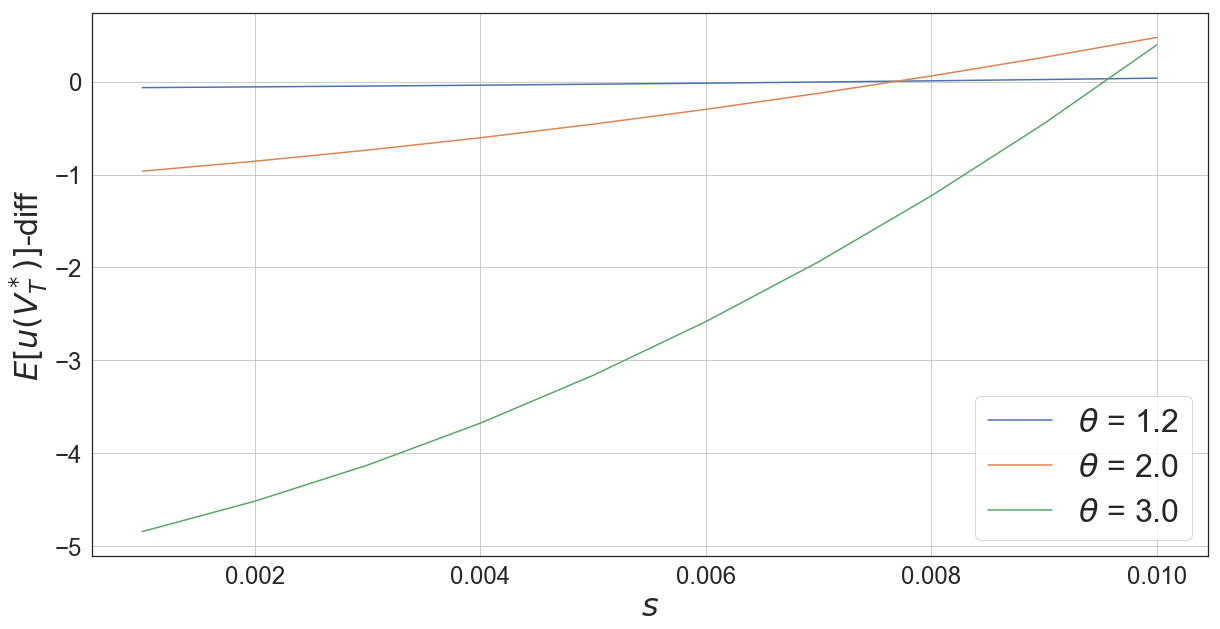

In [104]:
default_plot_normal_sigma(N, theta, u, d, p, default_value, mu, sigma)

In [78]:
seed = 123
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma=0.01

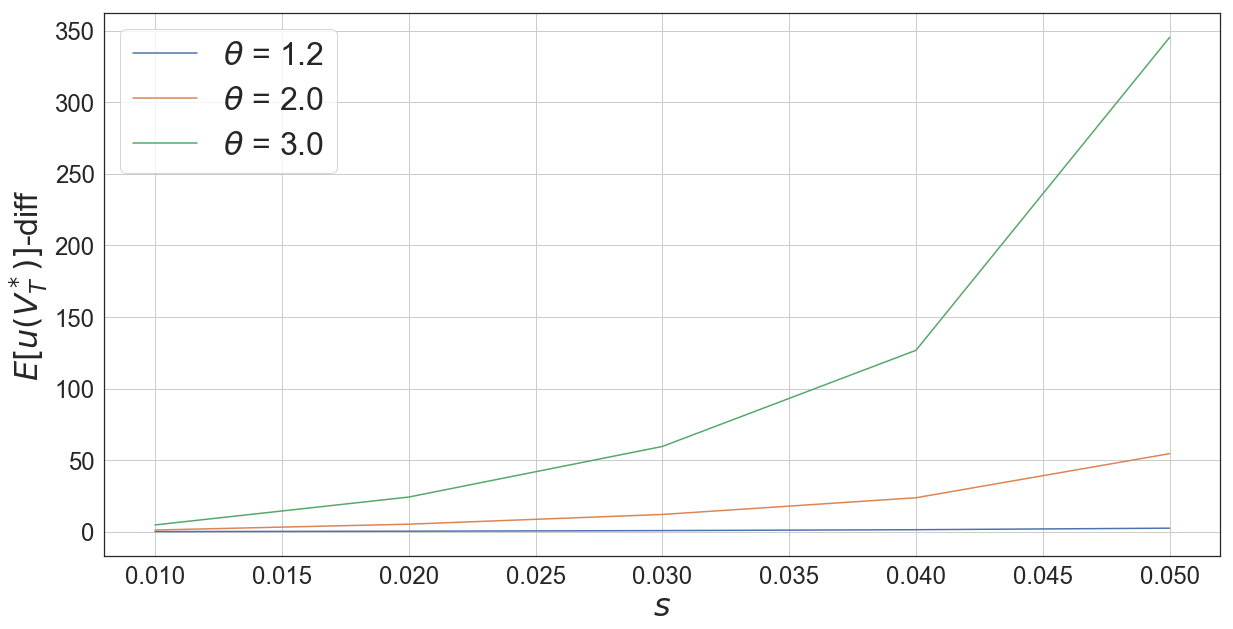

In [79]:
default_plot_normal_sigma(N, theta, u, d, p, default_value, mu, sigma)

In [80]:
seed = 1
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma=0.01

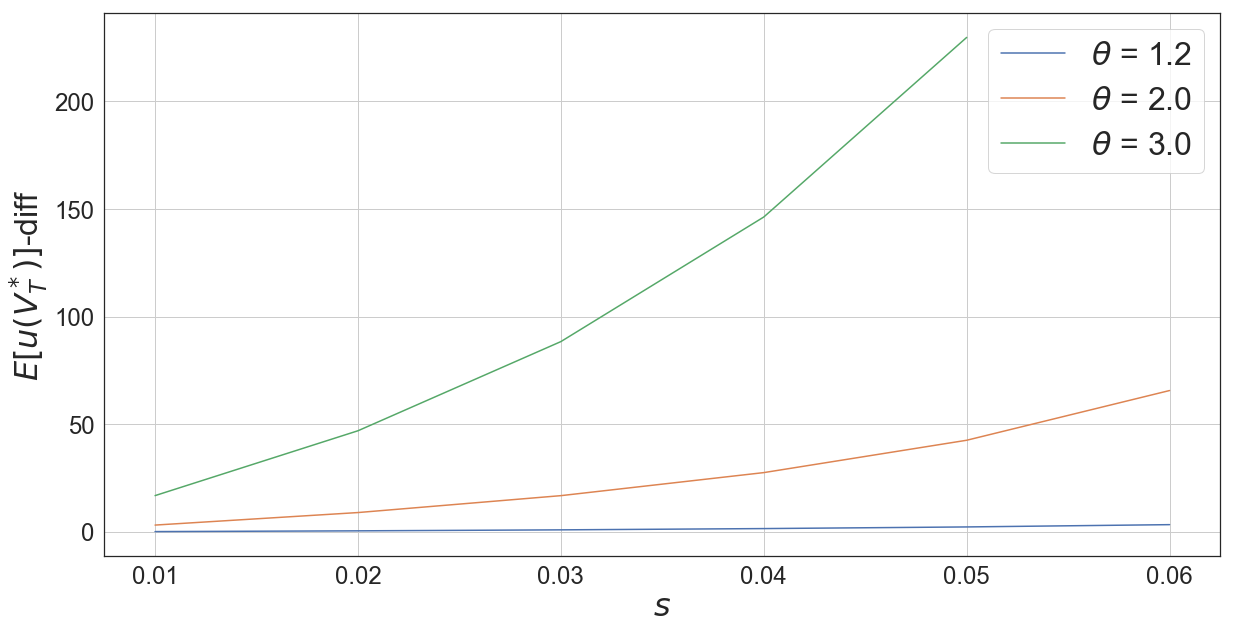

In [81]:
default_plot_normal_sigma(N, theta, u, d, p, default_value, mu, sigma)

In [99]:
seed = 123
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma=0.01

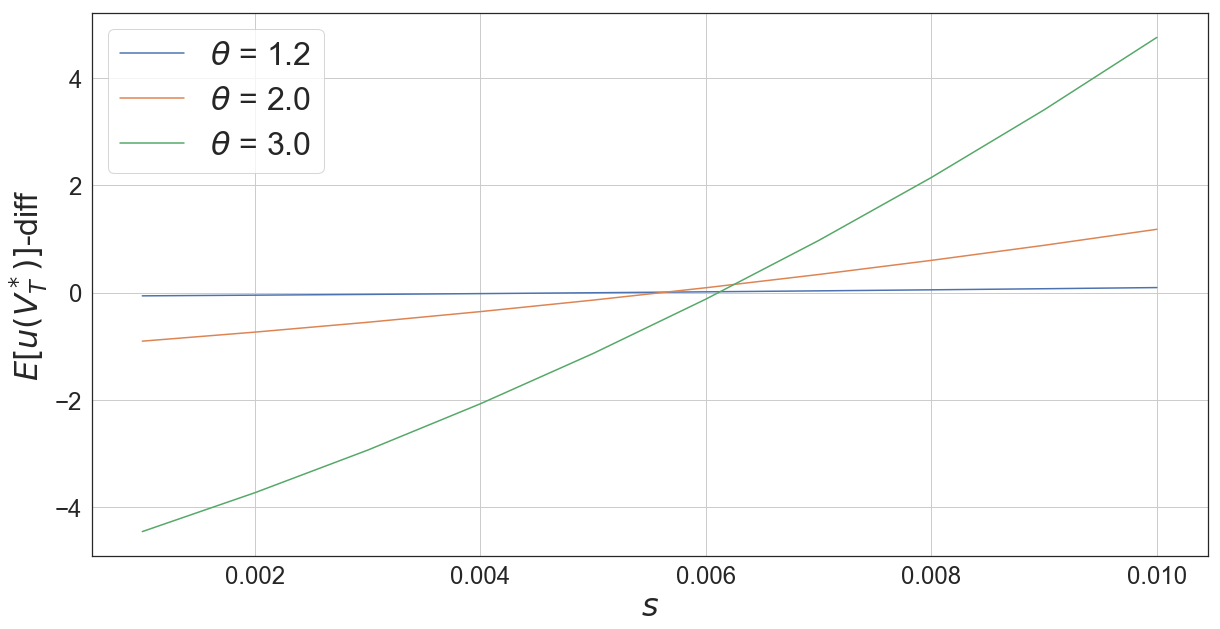

In [100]:
default_plot_normal_sigma(N, theta, u, d, p, default_value, mu, sigma)

In [101]:
seed = 1
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma=0.01

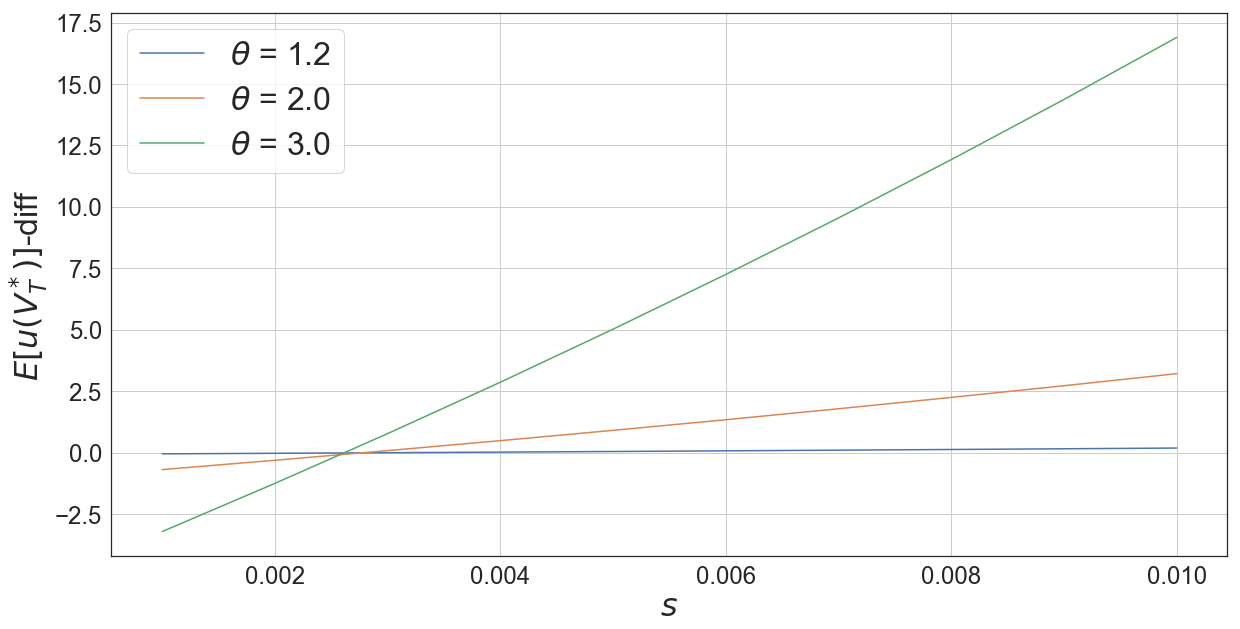

In [102]:
default_plot_normal_sigma(N, theta, u, d, p, default_value, mu, sigma)

In [87]:
seed = 12345
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma = 0.01

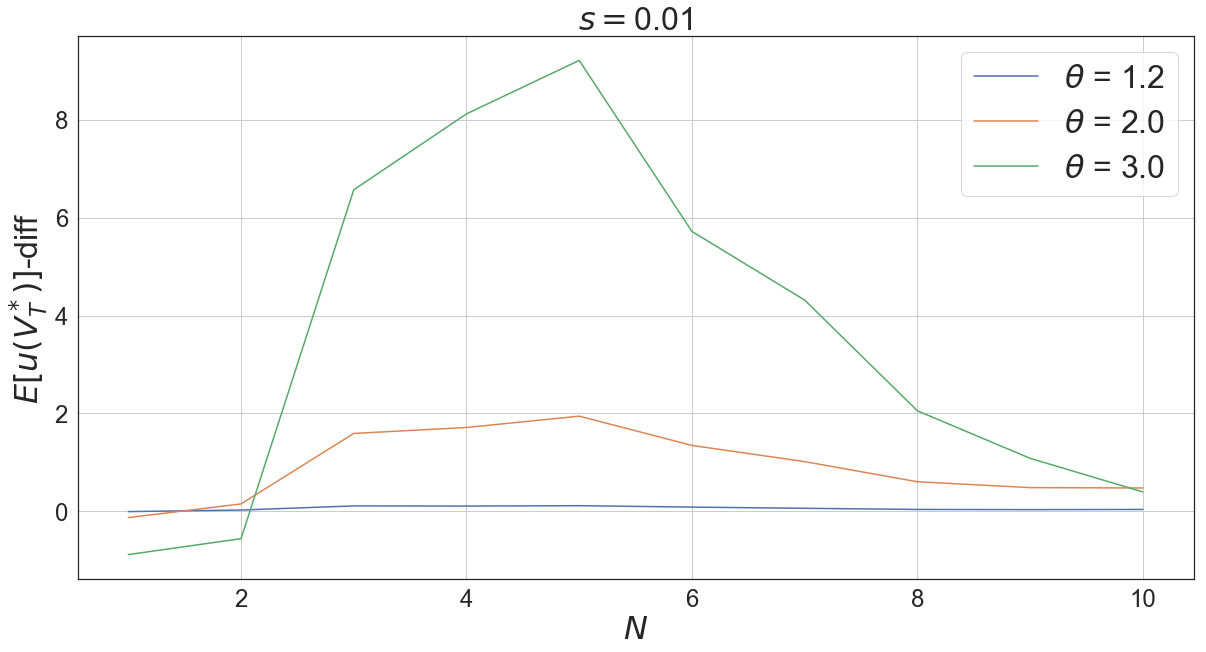

In [88]:
default_plot_normal_N(N, theta, u, d, p, default_value, mu, sigma)

In [89]:
seed = 123
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma = 0.01

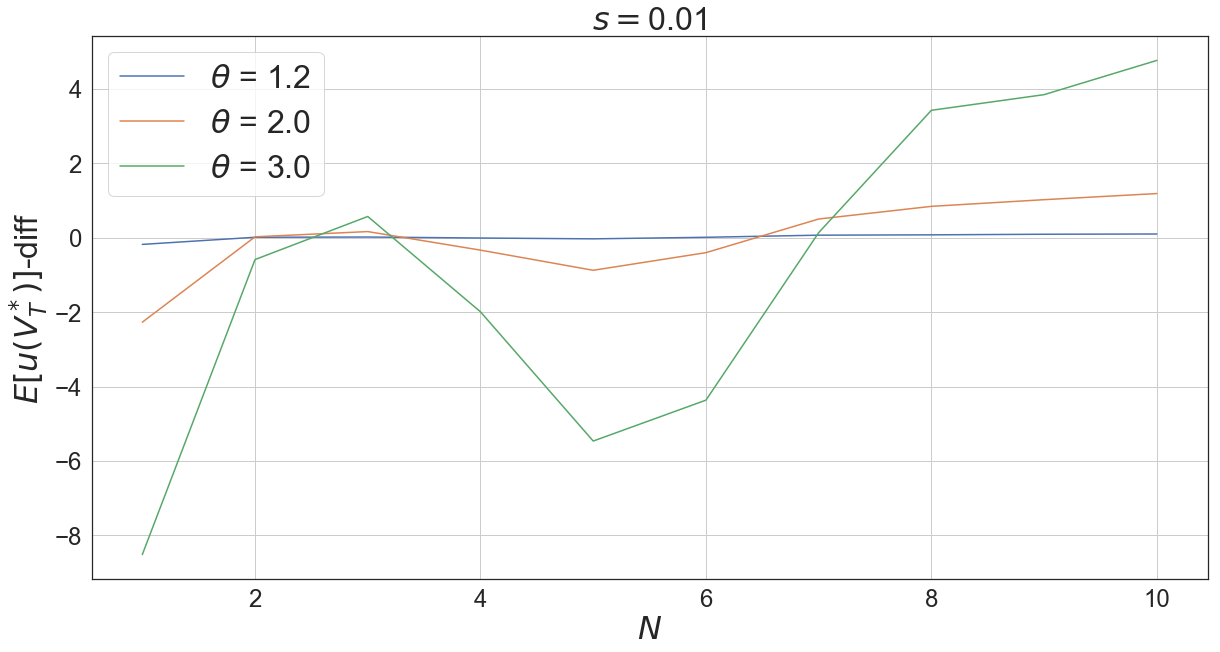

In [90]:
default_plot_normal_N(N, theta, u, d, p, default_value, mu, sigma)

In [91]:
seed = 1
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma = 0.01

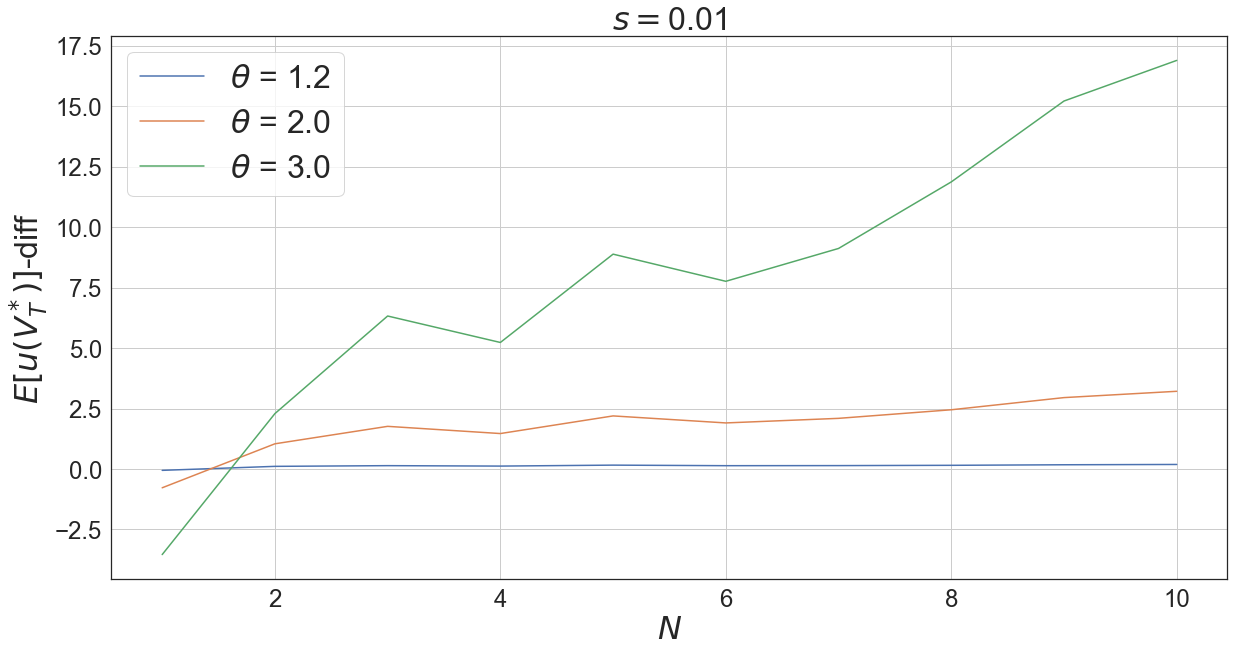

In [92]:
default_plot_normal_N(N, theta, u, d, p, default_value, mu, sigma)

In [93]:
seed = 12345
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma = 0.0075

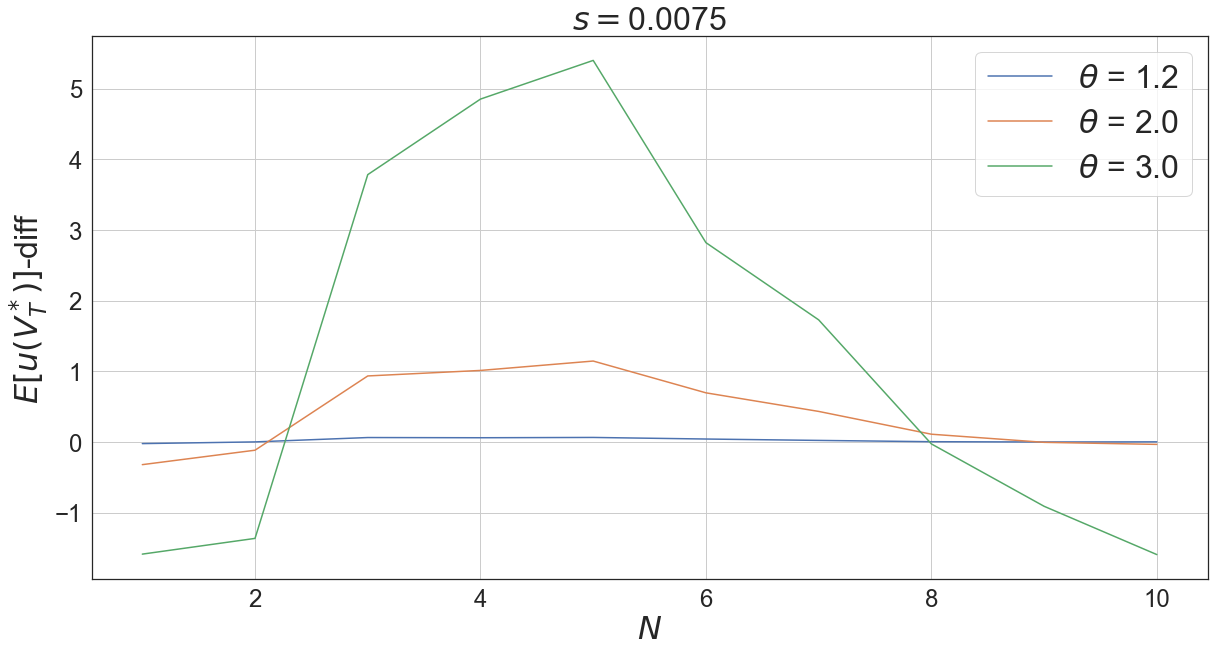

In [94]:
default_plot_normal_N(N, theta, u, d, p, default_value, mu, sigma)

In [95]:
seed = 123
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma = 0.0075

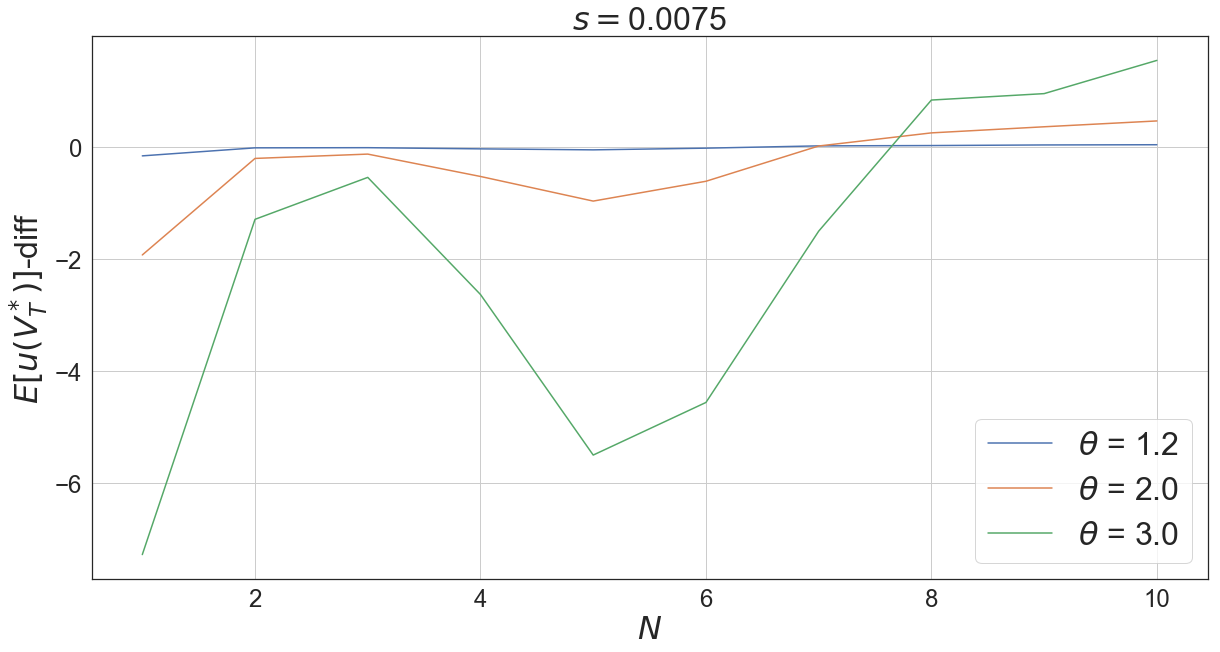

In [96]:
default_plot_normal_N(N, theta, u, d, p, default_value, mu, sigma)

In [105]:
seed = 1
N = 10
theta = 1.2
u = 1.2
d = 0.8
p = 0.4
default_value = 500
mu = 0
sigma = 0.0075

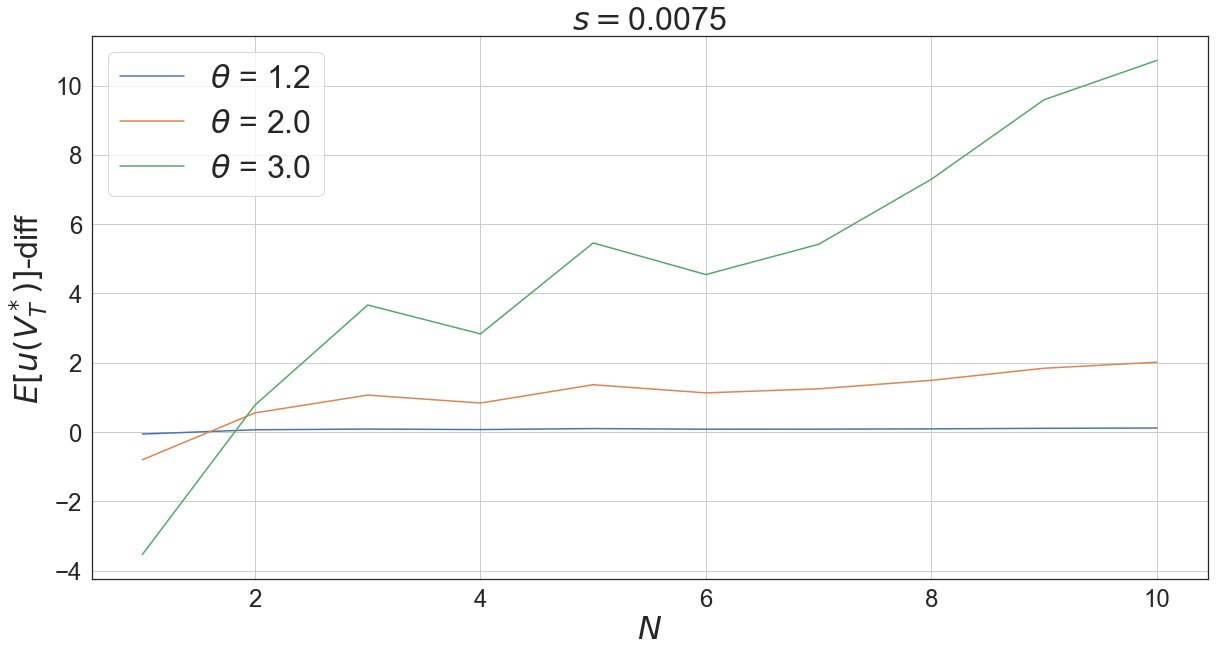

In [106]:
default_plot_normal_N(N, theta, u, d, p, default_value, mu, sigma)

In [97]:
def N_plot_normal(N, theta, u, d, p, default_value, mu, sigma):
    N_arr = []
    
    for i in range(1, 11):
        N_arr.append(i)
        forward_backward_diff = [list(map(lambda x: x, N_arr)), list(map(lambda x: sum(forward_normal_rand(x, theta, u, d, p, default_value, mu, sigma)["exp_U1"][x]) - sum(backward_normal_rand(x, theta, u, d, p, default_value, mu, sigma)["exp_utility"][x]), N_arr))]

    diff = pd.DataFrame(forward_backward_diff).T
    diff.columns = ["default", "Exp_diff"]

    diff_x = diff["default"]
    diff_y = diff["Exp_diff"]
    
    sns.set()
    sns.set_style('white')
    plt.figure(figsize=(20,10))
    plt.plot(diff_x, diff_y, label = "FW-DP-diff")

    plt.title(r"$\theta =$" +str(theta), fontsize=18)
    plt.xlabel(r"$x_0$", fontsize=18)
    plt.ylabel(r"$E[u(V_T^*)]$", fontsize=18)

    plt.legend(fontsize=18)
    return plt.show()

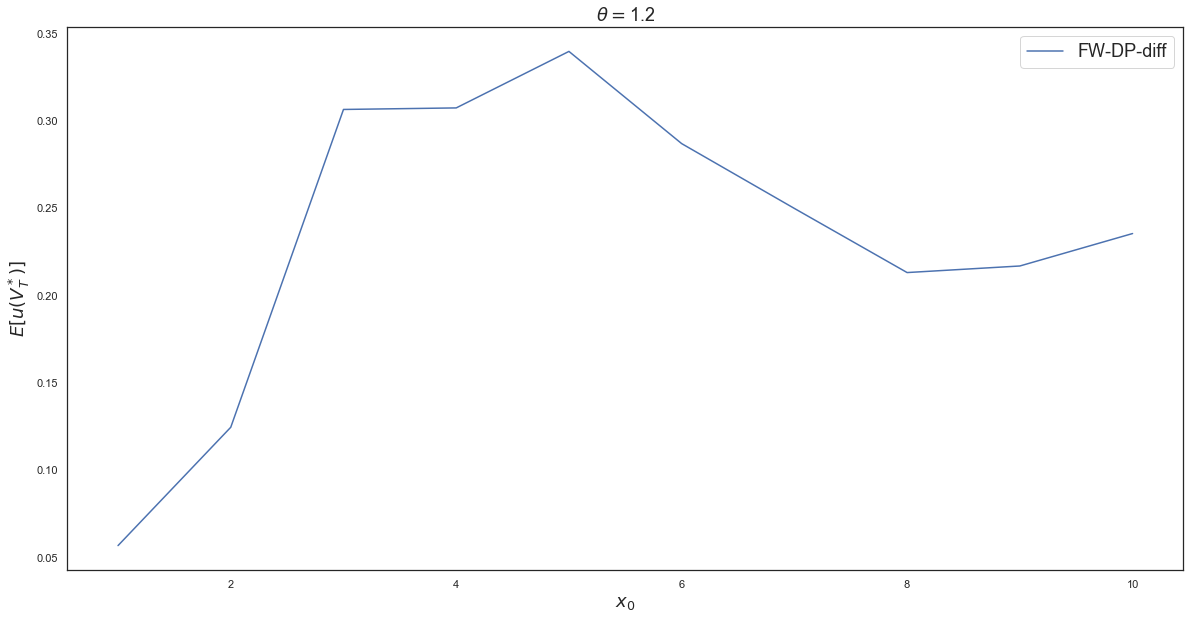

In [11]:
N_plot_normal(N, theta, u, d, p, default_value, mu, sigma)

In [28]:
def backward(N, theta, u, d, p, default_value):
    pi = ((((p*(u-1))/((1-p)*(1-d)))**theta)-1)/((u - 1)+(((p*(u-1))/((1-p)*(1-d)))**theta)*(1 - d))
    #bk_uniform_rand = bk.uniform_rand(N, seed)
    #bk_norm_rand = bk.norm_rand(N, seed, 0, 1)
    up_times = bk.up_times(N)
    down_times = bk.down_times(N)
    prm_theta = bk.prm_theta(N, theta)
    up_r = bk.up_r(N, u)
    down_r = bk.down_r(N, d)
    prob = bk.prob(N, p)
    prm_M = bk.prm_M(N, pi, prm_theta, up_r, down_r, prob)
    value = bk.value(N, pi, default_value, up_r, down_r)
    wealth = bk.wealth(N, prm_theta, prm_M, value)
    utility = bk.utility(N, prm_theta, value)
    exp_utility = bk.exp_utility(N, up_times, down_times, prob, utility)
    Wn = bk.Wn(N, up_times, down_times, prob, wealth)
    
    df_backward = pd.DataFrame([up_times, down_times, prm_theta, up_r, down_r, prob, prm_M, value, wealth, utility, exp_utility, Wn]).T
    df_backward.columns = ['up_times', 'down_times', 'prm_theta', 'up_r', 'down_r', 'prob', 'prm_M', 'value', 'wealth', 'utility', 'exp_utility', 'Wn']
    
    return df_backward#df_backward['exp_utility'][N], df_backward['wealth'][0] 

In [29]:
def forward(N, theta, u, d, p, default_value):
    #fw_uniform_rand = fw.uniform_rand(N, seed)
    #fw_norm_rand = fw.norm_rand(N, seed, 0, 1)
    up_times = fw.up_times(N)
    down_times = fw.down_times(N)
    prm_theta = fw.prm_theta(N, theta)
    up_r = fw.up_r(N, u)
    down_r = fw.down_r(N, d)
    prob = fw.prob(N, p)
    prm_q = fw.prm_q(N, up_r, down_r)
    prm_a = fw.prm_a(N, prob, prm_q)
    prm_b = fw.prm_b(N, prm_q)
    prm_c = fw.prm_c(N, prob, prm_q)
    delta = fw.delta(N, prm_theta, prm_a, prm_b, prm_c)
    pi = fw.pi(N, prm_theta, up_r, prob, prm_q, delta)
    value = fw.value(N, default_value, up_r, down_r, pi)
    U0 = fw.U0(N, prm_theta, value)
    I0 = fw.I0(N, prm_theta, value)
    I1 = fw.I1(N, delta, I0)
    U1 = fw.U1(N, prm_theta, delta, U0)
    exp_U1 = fw.exp_U1(N, up_times, down_times, prob, U1)
    
    df_forward = pd.DataFrame([up_times, down_times, prm_theta, up_r, down_r, prob, prm_q, prm_a, prm_b, prm_c, delta, pi, value, U0, I0, I1, U1, exp_U1]).T
    df_forward.columns = ['up_times', 'down_times', 'prm_theta', 'up_r', 'down_r', 'prob', 'prm_q', 'prm_a', 'prm_b', 'prm_c', 'delta', 'pi', 'value', 'U0', 'I0', 'I1', 'U1', 'exp_U1']
    
    return df_forward#df_forward["exp_U1"][N]

In [30]:
def default_plot_normal_N(N, theta, u, d, p, default_value):
    N_arr = []
    
    for i in range(1, 11):
        N_arr.append(i)
        forward_backward_diff_theta_12 = [list(map(lambda x: x, N_arr)), list(map(lambda x: sum(forward(x, 1.2, u, d, p, default_value)["exp_U1"][x]) - sum(backward(x, 1.2, u, d, p, default_value)["exp_utility"][x]), N_arr))]

    diff_theta_12 = pd.DataFrame(forward_backward_diff_theta_12).T
    diff_theta_12.columns = ["default", "Exp_diff"]

    diff_x_theta_12 = diff_theta_12["default"]
    diff_y_theta_12 = diff_theta_12["Exp_diff"]
    
    for i in range(1, 11):
        forward_backward_diff_theta_20 = [list(map(lambda x: x, N_arr)), list(map(lambda x: sum(forward(x, 2.0, u, d, p, default_value)["exp_U1"][x]) - sum(backward(x, 2.0, u, d, p, default_value)["exp_utility"][x]), N_arr))]

    diff_theta_20 = pd.DataFrame(forward_backward_diff_theta_20).T
    diff_theta_20.columns = ["default", "Exp_diff"]

    diff_x_theta_20 = diff_theta_20["default"]
    diff_y_theta_20 = diff_theta_20["Exp_diff"]
    
    for i in range(1, 11):
        forward_backward_diff_theta_30 = [list(map(lambda x: x, N_arr)), list(map(lambda x: sum(forward(x, 3.0, u, d, p, default_value)["exp_U1"][x]) - sum(backward(x, 3.0, u, d, p, default_value)["exp_utility"][x]), N_arr))]

    diff_theta_30 = pd.DataFrame(forward_backward_diff_theta_30).T
    diff_theta_30.columns = ["default", "Exp_diff"]

    diff_x_theta_30 = diff_theta_30["default"]
    diff_y_theta_30 = diff_theta_30["Exp_diff"]
       
    sns.set()
    sns.set_style('white')
    plt.figure(figsize=(20,10))
    plt.plot(diff_x_theta_12, diff_y_theta_12, label = r"$\theta$=1.2")
    plt.plot(diff_x_theta_20, diff_y_theta_20, label = r"$\theta$=2.0")
    plt.plot(diff_x_theta_30, diff_y_theta_30, label = r"$\theta$=3.0")

    plt.title(r"$\sigma =$" +str(theta), fontsize=32)
    plt.xlabel(r"$N$", fontsize=32)  
    plt.ylabel(r"$E[u(V_T^*)]$-diff", fontsize=32)
    plt.grid()
    
    plt.tick_params(labelsize=24)
    plt.legend(fontsize=32)
    return plt.show()

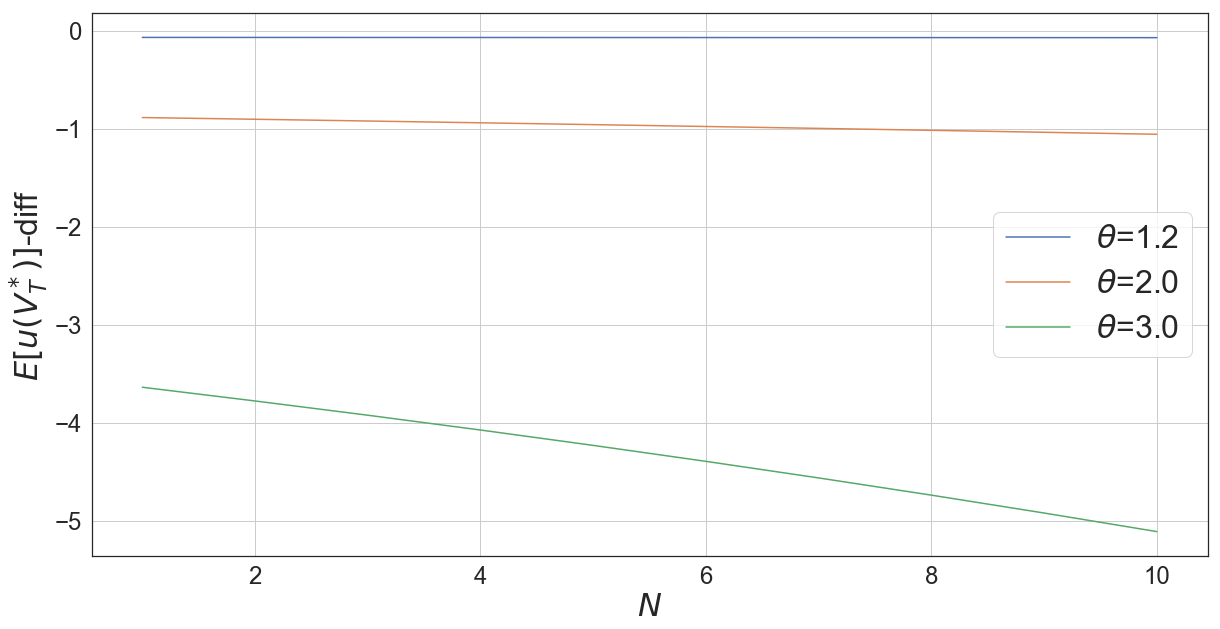

In [31]:
default_plot_normal_N(N, theta, u, d, p, default_value)